<a href="https://colab.research.google.com/github/iubordei/Ahorcado/blob/master/practica8_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 8. Ejercicio adicional 1: Sudoku. Parte II.

Este notebook es el menos guiado de la asignatura. El objetivo es combinar todo lo que hemos visto a lo largo del curso para leer un Sudoku y resolverlo. Para ello tendrás que utilizar lo visto en la práctica anterior, y además [un algoritmo para resolver Sudokus](http://norvig.com/sudoku.html). A la hora de leer los dígitos del Sudoku puedes utilizar cualquiera de estas aproximaciones:
- Utilizar propiedades de contornos como vimos en la práctica anterior. 
- [Utilizar la librería pytesseract](https://www.pyimagesearch.com/2020/09/21/opencv-automatic-license-number-plate-recognition-anpr-with-python/). 
- [Entrenar un modelo basado en el dataset MNIST](https://www.pyimagesearch.com/2020/08/10/opencv-sudoku-solver-and-ocr/).

**Librerías**

In [1]:
# Instalar
!pip install opencv-contrib-python
!pip install imutils
!pip install scikit-image
!pip install pytesseract
!apt install tesseract-ocr

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=7e59bdc21f877245493ec864971b882ed1705798e22dcdc5dea3b36a68b86e91
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,58

In [2]:
# Importar
import pytesseract
import numpy as np
import imutils
import cv2
from imutils import paths
import matplotlib.pyplot as plt
%matplotlib inline

**Funciones**

In [3]:
def build_tesseract_options(psm=7):
    # tell Tesseract to only OCR alphanumeric characters
    alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
    options = "-c tessedit_char_whitelist={}".format(alphanumeric)
    # set the PSM mode
    options += " --psm {}".format(psm)
    # return the built options string
    return options

In [4]:
def cross(A, B):
    "Cross product of elements in A and elements in B."
    return [a+b for a in A for b in B]

digits   = '123456789'
rows     = 'ABCDEFGHI'
cols     = digits
squares  = cross(rows, cols)
unitlist = ([cross(rows, c) for c in cols] +
            [cross(r, cols) for r in rows] +
            [cross(rs, cs) for rs in ('ABC','DEF','GHI') for cs in ('123','456','789')])
units = dict((s, [u for u in unitlist if s in u]) for s in squares)
peers = dict((s, set(sum(units[s],[]))-set([s])) for s in squares)

In [5]:
def test():
    "A set of unit tests."
    assert len(squares) == 81
    assert len(unitlist) == 27
    assert all(len(units[s]) == 3 for s in squares)
    assert all(len(peers[s]) == 20 for s in squares)
    assert units['C2'] == [['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2'],
                           ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'],
                           ['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3']]
    assert peers['C2'] == set(['A2', 'B2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2',
                               'C1', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
                               'A1', 'A3', 'B1', 'B3'])
    print('All tests pass.')

In [6]:
def parse_grid(grid):
    """Convert grid to a dict of possible values, {square: digits}, or
    return False if a contradiction is detected."""
    ## To start, every square can be any digit; then assign values from the grid.
    values = dict((s, digits) for s in squares)
    for s,d in grid_values(grid).items():
        if d in digits and not assign(values, s, d):
            return False ## (Fail if we can't assign d to square s.)
    return values

def grid_values(grid):
    "Convert grid into a dict of {square: char} with '0' or '.' for empties."
    chars = [c for c in grid if c in digits or c in '0.']
    assert len(chars) == 81
    return dict(zip(squares, chars))

In [7]:
def assign(values, s, d):
    """Eliminate all the other values (except d) from values[s] and propagate.
    Return values, except return False if a contradiction is detected."""
    other_values = values[s].replace(d, '')
    if all(eliminate(values, s, d2) for d2 in other_values):
        return values
    else:
        return False

def eliminate(values, s, d):
    """Eliminate d from values[s]; propagate when values or places <= 2.
    Return values, except return False if a contradiction is detected."""
    if d not in values[s]:
        return values ## Already eliminated
    values[s] = values[s].replace(d,'')
    ## (1) If a square s is reduced to one value d2, then eliminate d2 from the peers.
    if len(values[s]) == 0:
        return False ## Contradiction: removed last value
    elif len(values[s]) == 1:
        d2 = values[s]
        if not all(eliminate(values, s2, d2) for s2 in peers[s]):
            return False
    ## (2) If a unit u is reduced to only one place for a value d, then put it there.
    for u in units[s]:
        dplaces = [s for s in u if d in values[s]]
        if len(dplaces) == 0:
            return False ## Contradiction: no place for this value
        elif len(dplaces) == 1:
            # d can only be in one place in unit; assign it there
            if not assign(values, dplaces[0], d):
                return False
    return values

In [8]:
def display(values):
    "Display these values as a 2-D grid."
    width = 1+max(len(values[s]) for s in squares)
    line = '+'.join(['-'*(width*3)]*3)
    for r in rows:
        print(''.join(values[r+c].center(width)+('|' if c in '36' else '') for c in cols))
        if r in 'CF':
            print(line)
    print

In [9]:
def solve(grid): return search(parse_grid(grid))

def search(values):
    "Using depth-first search and propagation, try all possible values."
    if values is False:
        return False ## Failed earlier
    if all(len(values[s]) == 1 for s in squares): 
        return values ## Solved!
    ## Chose the unfilled square s with the fewest possibilities
    n,s = min((len(values[s]), s) for s in squares if len(values[s]) > 1)
    return some(search(assign(values.copy(), s, d)) 
		for d in values[s])

def some(seq):
    "Return some element of seq that is true."
    for e in seq:
        if e: return e
    return False

In [10]:
def tiene_num(casilla):
    w = casilla.shape[1]
    h = casilla.shape[0]
    options = build_tesseract_options(psm=7)
    for i in range(0, w-1):
        for j in range(0, h-1):
            (b, g, r) = casilla[i, j]
            if (b != 255) or (g != 255) or (r != 255):
                return pytesseract.image_to_string(casilla, config=options)[0]
    return '.'

**Código de la práctica 7, ampliación 2**

In [11]:
def sort_contours(cnts):
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),key=lambda b:(b[1][1],b[1][0]), reverse=False))
    return cnts

In [12]:
def generaTablero(imagen):
    clone = imagen.copy()
    gray = cv2.cvtColor(clone, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY_INV)[1]
    
    cnts,_ = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sort_contours(cnts)
    contornos = []
    
    for (i, c) in enumerate(cnts):
        # Calculamos diversas propiedades
        area = cv2.contourArea(c)
        (x, y, w, h) = cv2.boundingRect(c)
        aspectRatio = w / float(h)
        extent = area / float(w * h)
        hull = cv2.convexHull(c)
        hullArea = cv2.contourArea(hull)
        solidity = area / float(hullArea)
    
        if (solidity == 1.0) and (area > 1000) and (area < 2000):
            contornos.insert(i, c)
    
    boundingBoxes = [cv2.boundingRect(c) for c in contornos]
    cad = ''
    for (x, y, h, w) in boundingBoxes:
        cas = clone[y+3:y+w-3, x+3:x+h-3]
        cad += tiene_num(cas)
    
    return(cad)

In [13]:
def mostrarImagen(image):
    if len(image.shape)==3:
        img2 = image[:,:,::-1]
        plt.imshow(img2)
        plt.show()
    else:
        img2 = image
        plt.imshow(img2,cmap='gray')
        plt.show()

**Descargar imágenes de sudokus**

In [14]:
!wget https://github.com/IA1819/Datasets/blob/master/im%C3%A1genes.zip?raw=true -O imagenes.zip
!unzip imagenes.zip

--2021-04-29 17:35:48--  https://github.com/IA1819/Datasets/blob/master/im%C3%A1genes.zip?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IA1819/Datasets/raw/master/im%C3%A1genes.zip [following]
--2021-04-29 17:35:48--  https://github.com/IA1819/Datasets/raw/master/im%C3%A1genes.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IA1819/Datasets/master/im%C3%A1genes.zip [following]
--2021-04-29 17:35:48--  https://raw.githubusercontent.com/IA1819/Datasets/master/im%C3%A1genes.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response.

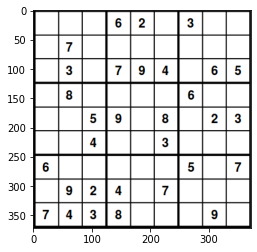

In [15]:
sudoku1 = cv2.imread("imágenes/sudoku1.png")
mostrarImagen(sudoku1)

In [16]:
generaTablero(sudoku1)

'...62.3...7........3.794.65.8....6....59.8.23..4..3...6.....5.7.924.7...7438...9.'

**Pruebas**

In [17]:
def resuelve(imagen):
    mostrarImagen(imagen)
    display(solve(generaTablero(imagen)))

In [18]:
s1 = cv2.imread("imágenes/sudoku1.png")
s2 = cv2.imread("imágenes/sudoku2.png")
s3 = cv2.imread("imágenes/sudoku3.png")

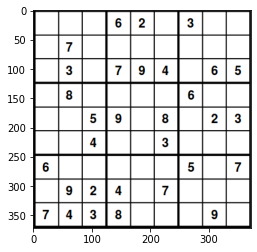

4 5 9 |6 2 1 |3 7 8 
2 7 6 |3 8 5 |9 1 4 
8 3 1 |7 9 4 |2 6 5 
------+------+------
3 8 7 |1 4 2 |6 5 9 
1 6 5 |9 7 8 |4 2 3 
9 2 4 |5 6 3 |7 8 1 
------+------+------
6 1 8 |2 3 9 |5 4 7 
5 9 2 |4 1 7 |8 3 6 
7 4 3 |8 5 6 |1 9 2 


In [19]:
resuelve(s1)

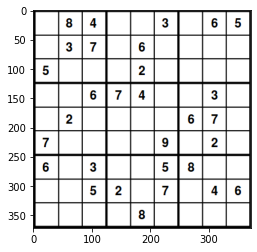

9 8 4 |1 7 3 |2 6 5 
2 3 7 |5 6 8 |4 1 9 
5 6 1 |9 2 4 |7 8 3 
------+------+------
1 5 6 |7 4 2 |9 3 8 
3 2 9 |8 5 1 |6 7 4 
7 4 8 |6 3 9 |5 2 1 
------+------+------
6 7 3 |4 1 5 |8 9 2 
8 1 5 |2 9 7 |3 4 6 
4 9 2 |3 8 6 |1 5 7 


In [20]:
resuelve(s2)

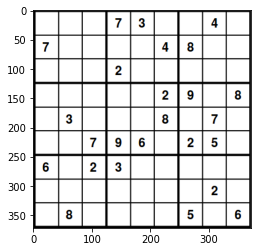

5 6 8 |7 3 9 |1 4 2 
7 2 1 |6 5 4 |8 9 3 
3 9 4 |2 8 1 |7 6 5 
------+------+------
4 5 6 |1 7 2 |9 3 8 
2 3 9 |5 4 8 |6 7 1 
8 1 7 |9 6 3 |2 5 4 
------+------+------
6 7 2 |3 1 5 |4 8 9 
1 4 5 |8 9 6 |3 2 7 
9 8 3 |4 2 7 |5 1 6 


In [21]:
resuelve(s3)

Al finalizar el notebook recuerda guardarlo usando la opción *"Save in Github..."*. 